# Snook

## Imports

In [1]:
import sys
sys.path.append("/usr/local/lib/python3.8/dist-packages/")
sys.path.append("../")

from PIL import Image
from utils import plot_inference

import os
import snook.data as sd
import snook.utils as su
import torch
import torch.nn.functional as F

## Detection and Classification

In [2]:
autoencoder = torch.jit.load("models/autoencoder.ts").eval().cuda()
classifier = torch.jit.load("models/classifier.ts").eval().cuda()

In [3]:
dataset = sd.ReMaHeDataset("dataset/test/renders", "dataset/test/data", spread=4.0)

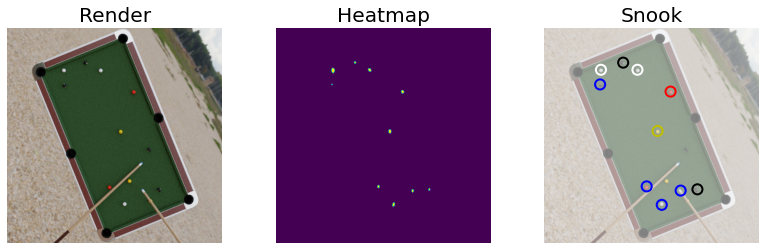

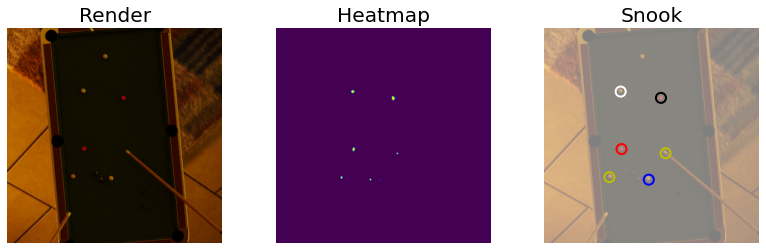

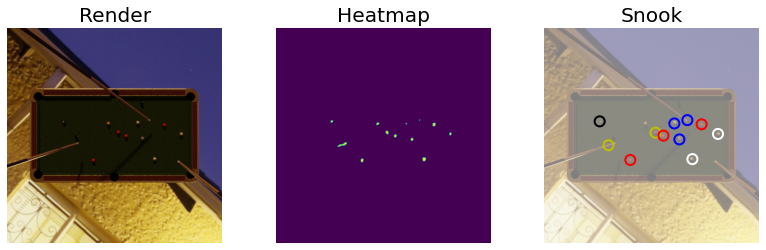

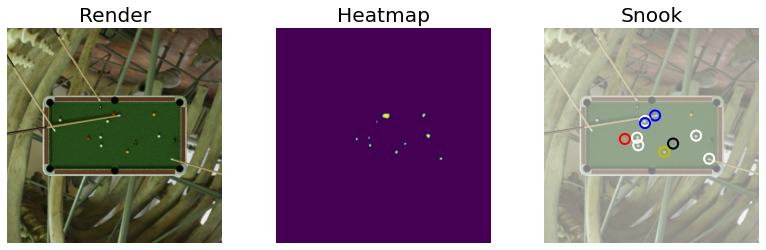

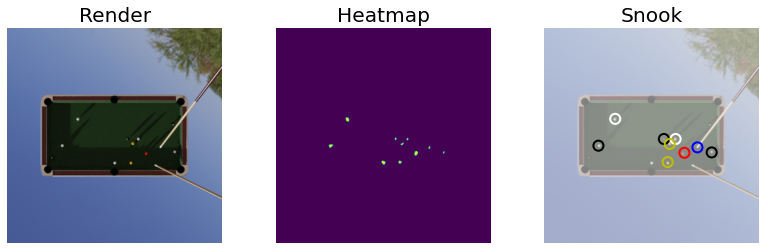

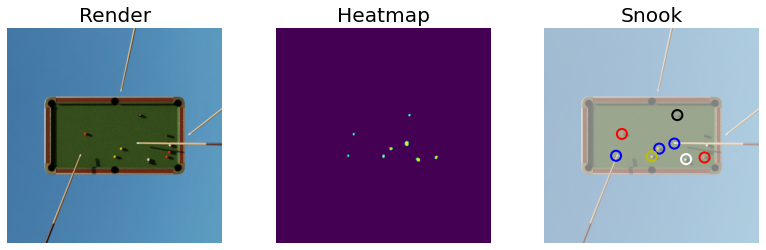

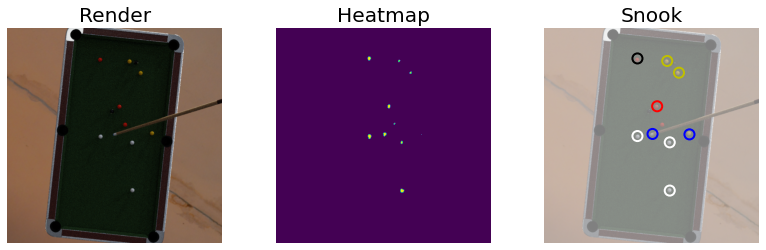

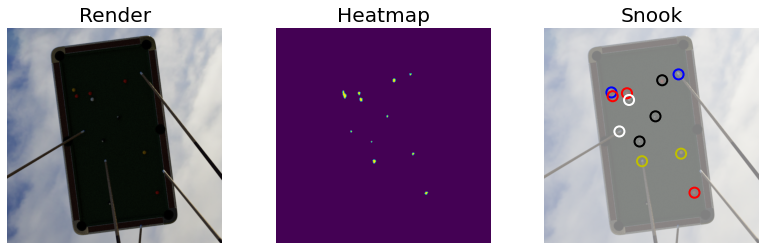

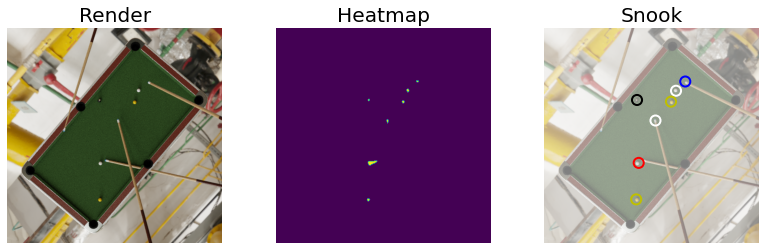

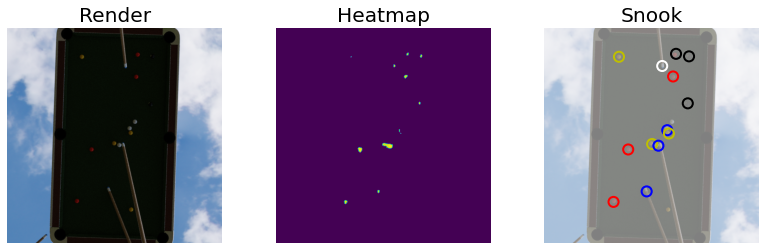

In [4]:
for i in range(10):
    render, _, _ = dataset[i]
    render = render.cuda()
    
    heatmap = torch.clamp(autoencoder(render.unsqueeze(0))[0, 0], 0, 1)
    heatmap[heatmap < 0.45] = 0
    
    peaks = su.peak_detection(heatmap)
    windows = su.peak_windows(render, peaks)
    
    logits = classifier(windows)
    probas = torch.softmax(logits, dim=0)
    labels = torch.argmax(probas, dim=-1)
    
    plot_inference(render, heatmap, peaks, labels)

## Performances

In [5]:
autoencoder.cpu()
classifier.cpu()

print("CPU Performances:")
%timeit autoencoder(torch.rand(1, 3, 512, 512))
%timeit classifier(torch.rand(1, 3, 64, 64))

CPU Performances:
40.7 ms ± 3.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
922 µs ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
autoencoder.cuda()
classifier.cuda()

print("GPU Performance:")
%timeit autoencoder(torch.rand(1, 3, 512, 512).cuda())
%timeit classifier(torch.rand(1, 3, 64, 64).cuda())

GPU Performance:
8.51 ms ± 60.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
730 µs ± 8.59 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
